# Thermochemical Equilibrium: Neutral ISM
Example of using `pism` to solve for thermochemical equilibrium in the unshielded neutral ISM. Line+recombination cooling balances photoelectric and cosmic ray heating, and gas-phase recombination balances cosmic-ray ionization.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
from matplotlib import pyplot as plt
import sympy as sp

## Defining the network

In [ ]:
from pism.processes import FreeFreeEmission, LineCoolingSimple, CollisionalIonization, GasPhaseRecombination, Ionization
processes = [CollisionalIonization(s) for s in ("H", "He", "He+")] + [GasPhaseRecombination(i) for i in ("H+", "He+", "He++")]
system = sum(processes)
system +=  sum([FreeFreeEmission(i) for i in ("H+", "He+", "He++")]) + sum([LineCoolingSimple(i) for i in ("H", "He+",)])

# throw in some order-of-magntiude numbers to model photoelectric heating and cosmic-ray ionization
heat_per_H = 1e-27
zeta_CR = 2e-16
system.heat += heat_per_H * sp.Symbol("n_Htot")
system += Ionization(species="H", rate_per_volume=zeta_CR* sp.Symbol("n_Htot"))
T = sp.Symbol("T")

# C+ cooling - assumes x_C+ = x_e- = 3e-4
x_C = 3e-4
system.heat -= 1e-27 * sp.Symbol("n_Htot") * sp.exp(-91.211 / T) * (4890 / sp.sqrt(T) *  (x_C * sp.Symbol("n_H")) + 0.47 * T**0.15 * sp.Symbol("n_Htot"))

# Solving thermochemical equilibrum

In [3]:
ngrid = np.logspace(-3,3,10**5)
Ygrid = 0.24*np.ones_like(ngrid)

knowns = {"n_Htot": ngrid, "Y": Ygrid} 

guesses = {
    "T": 100. * np.ones_like(ngrid),
    "H": ngrid*0.99, # density
    "He": 0.24/(4-4*0.24)*ngrid*0.99, #density 
    "He+": 0.24/(4-4*0.24)*ngrid*0.01 #density
}

sol = system.steadystate(knowns, guesses,tol=1e-3,input_abundances=False, output_abundances=True,careful_steps=30)
#sol = system.steadystate(knowns, sol,tol=1e-1,input_abundances=False, output_abundances=True,careful_steps=30)

#print(sol)
#Ionization()

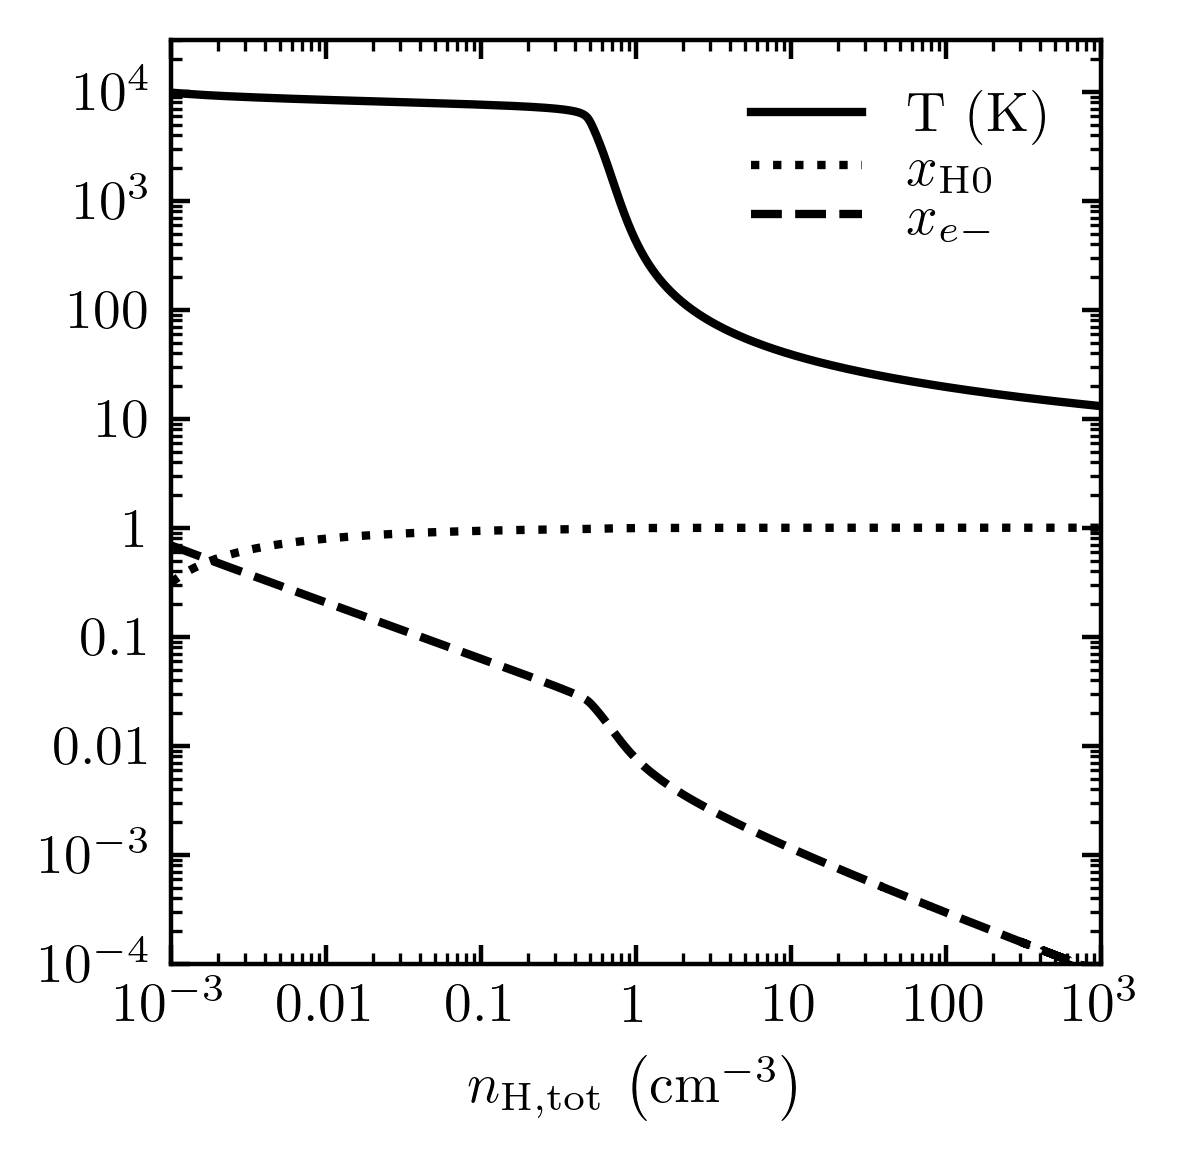

In [ ]:
fig, ax = plt.subplots(figsize=(3,3))
ax.loglog(ngrid,sol["T"],label=r"T (K)",color='black')
ax.loglog(ngrid,sol["H"],label=r"$x_{\rm H0}$",ls='dotted',color='black')
ax.loglog(ngrid,sol["e-"],label=r"$x_{e-}$",ls='dashed',color='black')
ax.set_xlabel(r"$n_{\rm H}\,\left(\rm cm^{-3}\right)$")
ax.legend(labelspacing=0)
ax.set_xlim(ngrid[0],ngrid[-1])
ax.set_ylim(1e-4,3e4)
ax.set_yticks(10.**np.arange(-4,5))